Dataset to be downloaded from: https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption#

In [1]:
import time
from keras.layers import LSTM
from keras.layers import Activation, Dense, Dropout
from keras.models import Sequential, load_model
from numpy.random import seed

from tensorflow import set_random_seed
set_random_seed(2)  # seed random numbers for Tensorflow backend
seed(1234)  # seed random numbers for Keras
import numpy as np
import csv
import matplotlib.pyplot as plt

%matplotlib inline


Using TensorFlow backend.


In [2]:
def load_data(dataset_path, sequence_length=60, prediction_steps=5, ratio_of_data=1.0):
    max_values = ratio_of_data * 2075259  # 2075259 is the total number of measurements from Dec 2006 to Nov 2010

    # Load data from file
    with open(dataset_path) as file:
        data_file = csv.reader(file, delimiter=";")
        power_consumption = []
        number_of_values = 0
        for line in data_file:
            try:
                power_consumption.append(float(line[2]))
                number_of_values += 1
            except ValueError:
                pass
            if number_of_values >= max_values:  # limit data to be considered by model according to max_values
                break

    print('Loaded data from csv.')
    windowed_data = []
    # Format data into rolling window sequences
    for index in range(len(power_consumption) - sequence_length):  # for e.g: index=0 => 123, index=1 => 234 etc.
        windowed_data.append(power_consumption[index: index + sequence_length])
    windowed_data = np.array(windowed_data)  # shape (number of samples, sequence length)

    # Center data
    data_mean = windowed_data.mean()
    windowed_data -= data_mean
    print('Center data so mean is zero (subtract each data point by mean of value: ', data_mean, ')')
    print('Data  : ', windowed_data.shape)

    # Split data into training and testing sets
    train_set_ratio = 0.9
    row = int(round(train_set_ratio * windowed_data.shape[0]))
    train = windowed_data[:row, :]
    x_train = train[:, :-prediction_steps]  # remove last prediction_steps from train set
    y_train = train[:, -prediction_steps:]  # take last prediction_steps from train set
    x_test = windowed_data[row:, :-prediction_steps]
    y_test = windowed_data[row:, -prediction_steps:]  # take last prediction_steps from test set

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test, data_mean]

In [3]:
def plot_predictions(result_mean, prediction_steps, predicted, y_test, global_start_time):
    try:
        test_hours_to_plot = 2
        t0 = 20  # time to start plot of predictions
        skip = 15  # skip prediction plots by specified minutes
        print('Plotting predictions...')
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(y_test[:test_hours_to_plot * 60, 0] + result_mean, label='Raw data')  # plot actual test series

        # plot predicted values from t0 to t0+prediction_steps
        plt.plot(np.arange(t0 - 1, t0 + prediction_steps),
                 np.insert(predicted[t0, :], 0, y_test[t0 - 1, 0]) + result_mean,
                 color='red', label='t+{0} evolution of predictions'.format(prediction_steps))
        for i in range(t0, test_hours_to_plot * 60, skip):
            t0 += skip
            if t0 + prediction_steps > test_hours_to_plot * 60:  # check plot does not exceed boundary
                break
            plt.plot(np.arange(t0 - 1, t0 + prediction_steps),
                     np.insert(predicted[t0, :], 0, y_test[t0 - 1, 0]) + result_mean, color='green')

        # plot predicted value of t+prediction_steps as series
        plt.plot(predicted[:test_hours_to_plot * 60, prediction_steps - 1] + result_mean,
                 label='t+{0} prediction series'.format(prediction_steps))

        plt.legend(loc='lower left')
        plt.ylabel('Actual Power in kilowatt')
        plt.xlabel('Time in minutes')
        plt.title('Predictions for first {0} minutes in test set'.format(test_hours_to_plot * 60))
        plt.show()
    except Exception as e:
        print(str(e))
    print('Duration of training (s) : ', time.time() - global_start_time)

    return None

In [4]:
def build_model(prediction_steps):
    model = Sequential()
    layers = [1, 75, 100, prediction_steps]
    model.add(LSTM(layers[1], input_shape=(None, layers[0]), return_sequences=True))  # add first layer
    model.add(Dropout(0.2))  # add dropout for first layer
    model.add(LSTM(layers[2], return_sequences=False))  # add second layer
    model.add(Dropout(0.2))  # add dropout for second layer
    model.add(Dense(layers[3]))  # add output layer
    model.add(Activation('linear'))  # output layer with linear activation
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print('Compilation Time : ', time.time() - start)
    return model

In [5]:
def run_lstm(model, sequence_length, prediction_steps):
    data = None
    global_start_time = time.time()
    epochs = 1
    ratio_of_data = 1  # ratio of data to use from 2+ million data points
    path_to_dataset = 'data/household_power_consumption.txt'

    if data is None:
        print('Loading data... ')
        x_train, y_train, x_test, y_test, result_mean = load_data(path_to_dataset, sequence_length,
                                                                  prediction_steps, ratio_of_data)
    else:
        x_train, y_train, x_test, y_test = data

    print('\nData Loaded. Compiling...\n')
    
    model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.05)
    predicted = model.predict(x_test)
    # predicted = np.reshape(predicted, (predicted.size,))
    model.save('LSTM_power_consumption_model.h5')  # save LSTM model

    plot_predictions(result_mean, prediction_steps, predicted, y_test, global_start_time)

    return None

Compilation Time :  0.010883808135986328
Loading data... 
Loaded data from csv.
Center data so mean is zero (subtract each data point by mean of value:  1.091607820345784 )
Data  :  (2049270, 10)

Data Loaded. Compiling...

Train on 1752125 samples, validate on 92218 samples
Epoch 1/1
1752125/1752125 [==============================] - 143s 82us/step - loss: 0.1915 - val_loss: 0.1549
Plotting predictions...


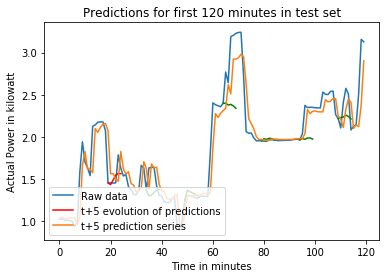

Duration of training (s) :  165.87630820274353


In [6]:
sequence_length = 10  # number of past minutes of data for model to consider
prediction_steps = 5  # number of future minutes of data for model to predict
model = build_model(prediction_steps)
run_lstm(model, sequence_length, prediction_steps)